In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import scipy

In [81]:
#import AA from parent directory
import torch
from torchAA import torchAA
from helpers.callbacks import EarlyStop

In [82]:
import sys
sys.path.append("../..")
from helpers.initializers import FurthestSum

In [83]:
# mat = scipy.io.loadmat('data/NMR_mix_DoE.mat')


# # Get X and Labels. Probably different for the other dataset, but i didn't check :)
# X = mat.get('xData')
# targets = mat.get('yData')
# target_labels = mat.get('yLabels')

# #convert target labels to colors in a dict

# # colors = {"Iris-setosa": "red", "Iris-versicolor": "blue", "Iris-virginica": "green"}
# colors = {target_labels[0]: "red", target_labels[1]: "blue", target_labels[2]: "green"}
# targets
# axis = mat.get("Axis")

In [84]:
# fig, axs = plt.subplots(1, 3, sharey=True)
# axs[0].plot(X[[np.all(x == [100, 0, 0]) for x in targets]][0], label="Propanol")
# axs[0].set_title("Propanol")
# axs[1].plot(X[[np.all(x == [0, 100, 0]) for x in targets]][0], label="Butanol")
# axs[1].set_title("Butanol")
# axs[2].plot(X[[np.all(x == [0, 0, 100]) for x in targets]][0], label="Pentanol")
# axs[2].set_title("Pentanol")
# plt.show()

In [85]:
df = pd.read_csv("iris.csv")
df.head()

,5.1,3.5,1.4,0.2,Iris-setosa
0,4.9,3.0,1.4,0.2,Iris-setosa
1,4.7,3.2,1.3,0.2,Iris-setosa
2,4.6,3.1,1.5,0.2,Iris-setosa
3,5.0,3.6,1.4,0.2,Iris-setosa
4,5.4,3.9,1.7,0.4,Iris-setosa


In [86]:
# #make a dataframe with only the first 2 and last column
df = df.iloc[:, [0,1,4]]

In [87]:
df

,5.1,3.5,Iris-setosa
0,4.9,3.0,Iris-setosa
1,4.7,3.2,Iris-setosa
2,4.6,3.1,Iris-setosa
3,5.0,3.6,Iris-setosa
4,5.4,3.9,Iris-setosa
...,...,...,...
144,6.7,3.0,Iris-virginica
145,6.3,2.5,Iris-virginica
146,6.5,3.0,Iris-virginica
147,6.2,3.4,Iris-virginica


In [88]:
# PC = PCA(n_components=2)
# X = PC.fit_transform(df.iloc[:,0:4].values)
X = df.iloc[:,0:2].values
# remove the first column
# X = X.T
# X = X[:,1:3]
X_plot = np.append(X, df.iloc[:,2:3], axis=1)
# append the labels to the data

In [89]:
#plot the data
#map the labels to colors
colors = {"Iris-setosa": "red", "Iris-versicolor": "blue", "Iris-virginica": "green"}
# plt.scatter(X_plot[:,0], X_plot[:,1], c=[colors[label] for label in X_plot[:,2]])
# plt.show()

In [90]:
#train the model
AA = torchAA(X.T, 3, initializer=1)
C, S = AA.fit(verbose=True, stopper=EarlyStop(patience=30, offset=-1e-5))

c:\Users\lucas\Documents\UNI\fagprojekt\02466Fagprojekt2023\Visualizations\AA\torchAA.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.C = torch.tensor(self.C, requires_grad=True)


In [91]:
print(X.shape)

(149, 2)


In [92]:
print(np.max(C))

0.64406043


In [93]:
print(C.shape)
print(S.shape)
print(X.shape)

(149, 3)
(3, 149)
(149, 2)


In [94]:
A = np.matmul(X.T, C)
rec = np.matmul(A, S)
#append the first element of A to the end of A
A = np.append(A, A[0:1,:], axis=0)

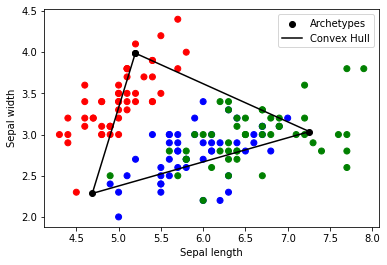

In [95]:
#plot the archetypes
plt.figure()

#matmul the archetypes with the data to get the reconstructed data
# A = np.matmul(C, X)
# recons = np.matmul(S, A)

plt.scatter(X[:,0], X[:,1], c=[colors[label] for label in X_plot[:,2]])

#draw lines between all the archetypes
# for i,vec in enumerate(A):
#     # plt.scatter(vec[0], vec[1], c="black")
#     plt.plot([A[i-1][0], vec[0]], [A[-1][1], vec[1]], c="black")
#     # plt.plot(A[i-1][0], A[i-1][1], c="black")


plt.scatter(A.T[:,0], A.T[:,1], c="black", label="Archetypes")

#draw lines between all the archetypes
plt.plot(A.T[:,0], A.T[:,1], c="black", label="Convex Hull")


# plt.title("Archetypes")
plt.xlabel("Sepal length")
plt.ylabel("Sepal width")
plt.legend()
plt.show()

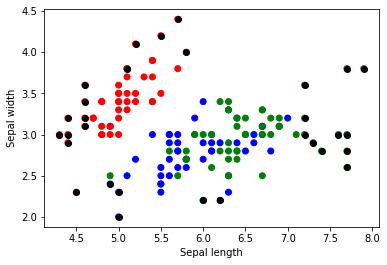

In [96]:
points = 30

inital_index = FurthestSum(X.T, points, 0)

plt.scatter(X[:,0], X[:,1], c=[colors[label] for label in X_plot[:,2]])

for i in inital_index:
    plt.scatter(X[i].T[0], X[i].T[1], label="First signal of X", color="black")

plt.xlabel("Sepal length")
plt.ylabel("Sepal width")
plt.show()

In [97]:
#show loss difference between furthest sum and random initialization
Random_loss = []
FurthestSum_loss = []

Random_epochs = []
FurthestSum_epochs = []

for i in range(250):
    AA = torchAA(X.T, 3)
    C, S, loss = AA.fit(verbose=False, stopper=EarlyStop(patience=30, offset=-1e-5), return_loss=True)
    Random_loss.append(AA.lossfn.forward(AA.forward()).item())
    Random_epochs.append(len(loss))
    
    
    AA = torchAA(X.T, 3, initializer=1)
    C, S, loss = AA.fit(verbose=True, stopper=EarlyStop(patience=10, offset=-1e-5), return_loss=True)
    FurthestSum_loss.append(AA.lossfn.forward(AA.forward()).item())
    FurthestSum_epochs.append(len(loss))
    
    

In [98]:
print(np.mean(Random_loss))
print(np.std(Random_loss))

print(np.mean(FurthestSum_loss))
print(np.std(FurthestSum_loss))

15.025382311769674
3.856027463154802
13.379023857969957
3.7650544425470103


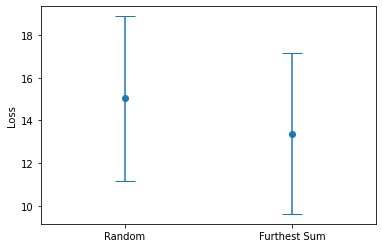

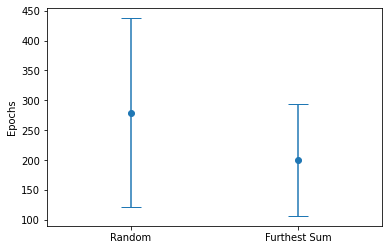

In [99]:
#plot two errorplots of the loss
# plt.bar(["Random", "Furthest Sum"], [np.mean(Random_loss), np.mean(FurthestSum_loss)], yerr=[np.std(Random_loss), np.std(FurthestSum_loss)])
# plt.boxplot([Random_loss, FurthestSum_loss], labels=["Random", "Furthest Sum"])
plt.errorbar(["Random", "Furthest Sum"], [np.mean(Random_loss), np.mean(FurthestSum_loss)], yerr=[np.std(Random_loss), np.std(FurthestSum_loss)], fmt='o', capsize=10)
plt.ylabel("Loss")
plt.xlim(-0.5, 1.5)
plt.show()

plt.errorbar(["Random", "Furthest Sum"], [np.mean(Random_epochs), np.mean(FurthestSum_epochs)], yerr=[np.std(Random_epochs), np.std(FurthestSum_epochs)], fmt='o', capsize=10)
plt.ylabel("Epochs")
plt.xlim(-0.5, 1.5)
plt.show()
